# Extract and fit spectra for the Chandra data

First, a warning: Standard Chandra data reducion uses a software colleciton called CIAO. CIAO is a set of programs and scripts for the command line, using parameter files or command line arguments. The most common use of CIAO is to either just type CIAO commands in the command line, have the CIAO command in a file and copy and paste them into a terminal or, for fancy people, scripts things in shell scripts.

However, in recent years, we've also started to provide an interface to call most (all?) CIAO routines from Python. As far as I can tell, that interface is certainly **not** widely used, but personally, I am much better (and much faster) scripting things in Python than in bash. So, I decided to give it a go. Also, as a secondary motivation, I'm working for the SDS group i nthe CXC that designs and specifcies (and implements some of) the tools and interfaces, so this seemed like a good opportunity for me to hit several goals that the same time: Making myself familiar with this intercface, testing the tools in a real world situation, and be able to integrate is all into one notebook. At this point, I'm not sure that's the most clever approach or if it would be better to split the notebook into "data reduction" because specifically generating arfs and rmfs can take a long time, and "fitting" where I'll have to tweak things more interactively. 

On the other hand, I'm currently using Sherpa for fitting instead of XSPEC (again, because sherpa is written in Python and I can use Python to loop over things and because I'm working in the group that develops Sherpa), so the fitting, plotting etc. works neatly in the same notebook.

I attempt to make scripts general, e.g. there is a function below for extracting a lightcurve. Currently, I'm only looking at one or two sources, but I'm expected to do the exact same analysi for many more sources, and I hope that the extra time to make it all general will pay of there.


In order to make this notebook more generally useful, I try to avoid hardocded absolute filepath. Instead, I have a softlink in my directory that is called "data" which points to:
/melkor/d1/guenther/downdata/Chandra/ONC/17735/
 
so the structure is as follows:

  - onc (my top level for this project)
    - analysis (the directory where this notebook sits
    - data
      - Chandra (a softline to the disk where I really store the data)
      - NuStar (not yet used)

Below, I'll just use the path "../data/Chandra" to point to the extraced data of OBSID 17735.
When I refer to the NuSTAR data (which I have not included in this notebook yet) then I'll make a softlink from ../data/Nustar.

In [61]:
import re
from pathlib import Path

import numpy as np
# I'm freely mixing astropy and CIAO for accessing fits files.
# While astropy is not part of the standard CIAO installation, it's easy to install
# with pip or conda.
# I'm just more familiar with astropy, so it's more convenient for me to use that to 
# e.g. just look up a fits header keyword, but I could to all the same things
# just with CIAO tools.
import ciao_contrib.runtool as rt
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from cycler import cycler

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
evtfile = '../data/Chandra/repro/evt'

In [63]:
# normalization for apec model in XPEC is 1e-14 / (4 pi d**2) for d in cm
# Distance from bibcode 2009ApJ...700..137R
normfac = 1e-14 / 4/ np.pi / (412 * u.pc.to(u.cm))**2

In [5]:
def build_lcs(evtfile, src, sky_src, sky_bkg, 
              energies=[(500,2000), (2000, 4000), (4000, 10000), (500, 10000)], 
              timedel=1000, lc_file='lc.fits'):
    filename = Path(lc_file)
    filename.parent.mkdir(parents=True, exist_ok=True)
    rt.dmextract.punlearn()
    # Build stack of input in dm stack syntax
    # to make several lightcurves of the same object and in the same binning
    # but for different energy ranges
    infiles = [evtfile + "[sky={}][energy={}:{}][bin time=::{}]".format(sky_src,
                                                                        en[0], en[1], timedel)
               for en in energies]
    bkgfiles = [evtfile + "[sky={}][energy={}:{}]".format(sky_bkg, en[0], en[1])
                   for en in energies]
    rt.dmextract(infile=','.join(infiles), 
                 bkg=','.join(bkgfiles), 
                 outfile=filename,
                 opt="ltc2", clobber=True)
    
def HR(band1, band2):
    return (band1-band2) / (band1 + band2)

## A detailed look at source COUP 1384

For a first look, I'll pick one particular source with a nice flare that's fully withint the observation window. As we will wee below, I happed to take a source that dithers over a chip gap, so the lightcurve does not look to nice by itself, but all the spectral analysys should be fine.

I did not yet integrate any of the NuStar data. Below, I try to keep the code that I write general, because I hope that I eventually can loop over all the sources that have big flares and while the NuStar data is still missing, there should be no problem in principle to integrate it into the analysis. It might require some more hand-work to set up the models in the fitting.

In [6]:
# Might want to code a loop to handle more than one source but for now, just put values in here.
src = 'COUP1384'
sky_src = "circle(5:35:27.45,-5:26:28,0.07')"
sky_bkg = "circle(5:35:27.3,-5:26:57,0.35')"

### Ligthcurve

In [7]:
build_lcs(evtfile, src, sky_src, sky_bkg, lc_file=f'../data/Chandra/individual/{src}/lc.fits')

In [8]:
build_lcs(evtfile, src, sky_src, sky_bkg, timedel=100, 
          lc_file=f'../data/Chandra/individual/{src}/lc.fits')

In [9]:
from matplotlib.ticker import AutoMinorLocator
custom_cycler = (cycler(color=['#d62728', '#ff7f0e', '#1f77b4', 'k']) +
                 cycler(lw=[2, 2, 2, 3]))

In [10]:
def plot_lc(ax, filename):
    lc = Table.read(filename, hdu=1)
    enlimits = re.compile('\[energy=(?P<enlow>[0-9]+):(?P<enhigh>[0-9]+)\]')

    ax.set_prop_cycle(custom_cycler)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.grid(True, which='both')
    axt = ax.twinx()
    for row in lc:
        enlow, enhigh = enlimits.search(row['SELECT']).groups()
        ax.plot((row['TIME'] - row['TIME'][0]), row['COUNTS'],
                label='{:4.1f}-{:4.1f} keV'.format(float(enlow) / 1e3, float(enhigh) / 1e3))
    
    axt.plot((row['TIME'] - row['TIME'][0]), 
            HR(lc['COUNT_RATE'][1] + lc['COUNT_RATE'][2], lc['COUNT_RATE'][0]), alpha=.3, color='k', lw=10)
    out = ax.legend()

/nfs/melkor/d1/guenther/soft/anaconda/envs/sherpaciao/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


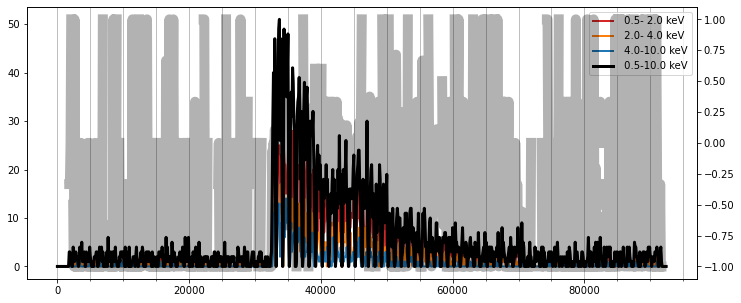

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
plot_lc(ax, f'../data/Chandra/individual/{src}/lc.fits')

This source shows some very suspicious up and down. I suspect that it is dithering through a chip gap. To check that, I'll look at a finer binned lightcurve below and zoom in a little bit. 

/nfs/melkor/d1/guenther/soft/anaconda/envs/sherpaciao/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


(30000.0, 40000.0)

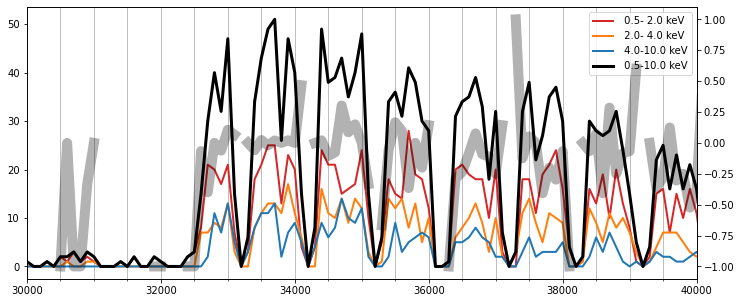

In [12]:
## Dithers into and out of a chip gap!

fig, ax = plt.subplots(figsize=(12,5))
plot_lc(ax, f'../data/Chandra/individual/{src}/lc.fits')
ax.set_xlim(30000, 40000)

Indeed, it's pretty clear that the short term changes are part of the dither pattern but the rise and long-term decay is much longer than the Chandra dither pattern, so those are real. So, we have to be a little careful with this (e.g. we probably don't want ot run a Fourier transform on it). Maybe this is not the best source to start the analysis. Fortunately, the tools that make arf and rmf take the dithering itno account when extracting spectra and the lightcurve plots are good enough for me to decide which parts to extact to get a pre-flare spectrum, a peak spectrum, and one or two spectra during the decay.

### Spectra

In [13]:
# Just copy the source region events into their own fits file. That way, I can open it later with
# e.g. astropy if I want to look at the table by hand.
# Not really needed, but I like to have the file handy if I want to check something.
rt.dmcopy(infile=evtfile + f"[sky={sky_src}]", outfile=f'../data/Chandra/individual/{src}/src.evt',
         clobber=True)

In [14]:
def build_spectra(evtfile, sky_scr, sky_bkg, times, **kwargs):
    rt.specextract.punlearn()

    infiles = [evtfile + "[time={}:{}][sky={}]".format(t[0], t[1], sky_src) for t in times]
    bkgfiles = [evtfile + "[time={}:{}][sky={}]".format(t[0], t[1], sky_bkg) for t in times]

    rt.specextract(infile=','.join(infiles), bkgfile=','.join(bkgfiles), **kwargs)

Now, I will extract spectra for the source I've chosen as an example. I do two separate extraction here:

  1. Four relatively broad time bins (flat, flare peak, decay, flat again). Files are called "spec_XXX".
  2. Seven smaller time bins because I expect to see continuous variation of the temperature in the flare during the decay phase. Files are called "spec_many_XXX".
  
 All extraction will be stored in a new directory within my data directory called Chandra/individual/src_name, thus I do not include the source name into the file path. I'll have to be a little careful below to keep track which files comes from which source when I load files form multiple sources at the saem time.

In [15]:
# Time is in seconds since Chandra's lauch, so I add the start time from the header
# to the times that I've read of my lightcurve plot above
times = fits.getval(evtfile, 'TSTART') + \
np.array([[0, 31000], [32000, 40000], [40000, 70000], [70000, 90000]])

build_spectra(evtfile, sky_src, sky_bkg, times, 
              outroot=f'../data/Chandra/individual/{src}/spec', 
              clobber=True, grouptype='NONE', binspec='NONE', weight=False, correctpsf=True)

In [39]:
spec_many_times = np.array([[0, 32500], [32500, 36000], [36000, 40000], 
                  [40000, 50000], [50000, 60000], [60000, 70000], [70000, 90000]])        

build_spectra(evtfile, sky_src, sky_bkg,
              fits.getval(evtfile, 'TSTART') + spec_many_times 
              outroot=f'../data/Chandra/individual/{src}/spec_many', 
              clobber=True, grouptype='NONE', binspec='NONE')

In [19]:
from glob import glob
from sherpa.astro import ui
from sherpa.astro import datastack as dsmod

"datastack" is a realtively little used feature in sherpa that allows us to handle "stacks" of spectra that are treated similar without writing for-loops for every command, e.g. if we want to bin the spectra to have 15 counts / bin, we just call the `bin_counts` methods on the datastack object, which will then executre the for-loop under the hood. More importantly though, we can set models on the stack with several components, where some of the components are the same for all spectra and some are not. I'll use a model with an absorption component and two VAPEC components (although I'll leave all elements frozen for this source since default abundances seem to work just fine). The absorption is to account for the cloud material in the ONC and any circumstellar matter and is probably the same for all spectra in the time series if a single source. I also leave one VAPEC component to be the saem for all spectra. I'm thinking that this component represents the accretion shock and the part of the corona that does not flare. (Sure, in reality that might be more than one temperature, but with the current level of ACIS contamination we don't see any soft plasma and it turns out that the firts look really good.) The other component I'll name `v__ID` and that means that datastack will create a new model component for each spectrum in the datatsack, called `v1` doe the spectraum wit hthe sherpa id `1`, `v2` etc.

Full docs for datastack are here https://cxc.harvard.edu/sherpa/ahelp/datastack.html
I find that to be one of the features that make sherpa much easier to use then XSPEC, in particualr if I have to repeat all the steps for many different sources, but, to be honest, it's a while since I've tried ot do an analysis like this in XPEC so maybe the interface has also improved.

In [20]:
pifiles = glob(f'../data/Chandra/individual/{src}/spec_src*.pi')
pifiles.sort()
ds = dsmod.DataStack()
for f in pifiles:
    ds.load_data(f)

read ARF file ../data/Chandra/individual/COUP1384/spec_src1.corr.arf
read RMF file ../data/Chandra/individual/COUP1384/spec_src1.rmf
read ARF (background) file ../data/Chandra/individual/COUP1384/spec_bkg1.arf
read RMF (background) file ../data/Chandra/individual/COUP1384/spec_bkg1.rmf
read background file ../data/Chandra/individual/COUP1384/spec_bkg1.pi
read ARF file ../data/Chandra/individual/COUP1384/spec_src2.corr.arf
read RMF file ../data/Chandra/individual/COUP1384/spec_src2.rmf
read ARF (background) file ../data/Chandra/individual/COUP1384/spec_bkg2.arf
read RMF (background) file ../data/Chandra/individual/COUP1384/spec_bkg2.rmf
read background file ../data/Chandra/individual/COUP1384/spec_bkg2.pi
read ARF file ../data/Chandra/individual/COUP1384/spec_src3.corr.arf
read RMF file ../data/Chandra/individual/COUP1384/spec_src3.rmf
read ARF (background) file ../data/Chandra/individual/COUP1384/spec_bkg3.arf
read RMF (background) file ../data/Chandra/individual/COUP1384/spec_bkg3.rmf

In [21]:
pifiles = glob(f'../data/Chandra/individual/{src}/spec_many_src*.pi')
pifiles.sort()
ds2 = dsmod.DataStack()
for f in pifiles:
    ds2.load_data(f)

read ARF file ../data/Chandra/individual/COUP1384/spec_many_src1.arf
read RMF file ../data/Chandra/individual/COUP1384/spec_many_src1.rmf
read ARF (background) file ../data/Chandra/individual/COUP1384/spec_many_bkg1.arf
read RMF (background) file ../data/Chandra/individual/COUP1384/spec_many_bkg1.rmf
read background file ../data/Chandra/individual/COUP1384/spec_many_bkg1.pi
read ARF file ../data/Chandra/individual/COUP1384/spec_many_src2.arf
read RMF file ../data/Chandra/individual/COUP1384/spec_many_src2.rmf
read ARF (background) file ../data/Chandra/individual/COUP1384/spec_many_bkg2.arf
read RMF (background) file ../data/Chandra/individual/COUP1384/spec_many_bkg2.rmf
read background file ../data/Chandra/individual/COUP1384/spec_many_bkg2.pi
read ARF file ../data/Chandra/individual/COUP1384/spec_many_src3.arf
read RMF file ../data/Chandra/individual/COUP1384/spec_many_src3.rmf
read ARF (background) file ../data/Chandra/individual/COUP1384/spec_many_bkg3.arf
read RMF (background) file

In [25]:
ds2.show_stack()

5: ../data/Chandra/individual/COUP1384/spec_many_src1.pi OBS_ID: 17735 MJD-OBS: N/A
6: ../data/Chandra/individual/COUP1384/spec_many_src2.pi OBS_ID: 17735 MJD-OBS: N/A
7: ../data/Chandra/individual/COUP1384/spec_many_src3.pi OBS_ID: 17735 MJD-OBS: N/A
8: ../data/Chandra/individual/COUP1384/spec_many_src4.pi OBS_ID: 17735 MJD-OBS: N/A
9: ../data/Chandra/individual/COUP1384/spec_many_src5.pi OBS_ID: 17735 MJD-OBS: N/A
10: ../data/Chandra/individual/COUP1384/spec_many_src6.pi OBS_ID: 17735 MJD-OBS: N/A
11: ../data/Chandra/individual/COUP1384/spec_many_src7.pi OBS_ID: 17735 MJD-OBS: N/A


In [26]:
ui.ignore(None, .4)
ui.ignore(10., None)

In [27]:
ds.set_source('xswabs.absall * (xsvapec.vall + xsvapec.v__ID)')

In [28]:
ds.fit()

Datasets              = 1, 2, 3, 4
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 4.70942e+09
Final fit statistic   = 418.184 at function evaluation 195
Data points           = 2624
Degrees of freedom    = 2613
Probability [Q-value] = 1
Reduced statistic     = 0.16004
Change in statistic   = 4.70942e+09
   absall.nH      0.060077     +/- 0.0397474   
   vall.kT        3.44461      +/- 1.63158     
   vall.norm      0.000162708  +/- 2.81192e-05 
   v1.kT          1.03643      +/- 0.180218    
   v1.norm        3.24328e-05  +/- 1.5027e-05  
   v2.kT          5.31616      +/- 0.713234    
   v2.norm        0.00349085   +/- 0.000187407 
   v3.kT          4.3189       +/- 0.824108    
   v3.norm        0.000932703  +/- 5.93082e-05 
   v4.kT          1.04298      +/- 0.194348    
   v4.norm        3.81955e-05  +/- 1.68012e-05 


In [29]:
from matplotlib import ticker

class MyLogFormatter(ticker.LogFormatter):
    '''Improved numbering for range .2 to 30
    
    The `matplotlib.ticker.LogFormatter` uses exponential
    notation for 6e-01, when I would prefer "0.6" for readability.
    This energy range is common in X-ray plot
    and this Formatter uses a more pleasing notation.
    '''
    def __init__(self, base=10.0, labelOnlyBase=False,
                 minor_thresholds=(2, .5),
                 linthresh=None):
        super().__init__(base, labelOnlyBase, minor_thresholds, linthresh)
    
    def _num_to_string(self, x, vmin, vmax):
        return self._pprint_val(x, vmax - vmin)
    
    def _pprint_val(self, x, d):
        # If the number is not too big and it's an int, format it as an int.
        if abs(x) < 1e4 and x == int(x):
            return '%d' % x
        fmt = ('%1.3e' if d < 1e-2 else
               '%1.3f' if d <= 1 else
               '%1.2f' if d <= 10 else
               '%1.1f' if d <= 1e5 else
               '%1.1e')
        s = fmt % x
        tup = s.split('e')
        if len(tup) == 2:
            mantissa = tup[0].rstrip('0').rstrip('.')
            exponent = int(tup[1])
            if exponent:
                s = '%se%d' % (mantissa, exponent)
            else:
                s = mantissa
        else:
            s = s.rstrip('0').rstrip('.')
        return s

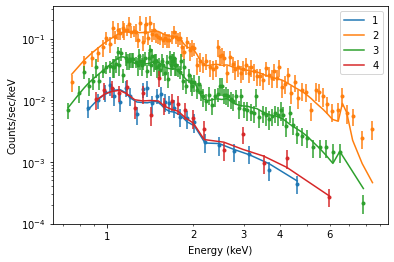

In [240]:
# Group for plotting purposes
ds.group_counts(15)
# Need to group again, because sometimes edges of the new grouping don't align
# with the energy limits given before
ui.ignore(None, .4)
ui.ignore(10., None)

for i in ds.get_stack_ids():
    dp = ui.get_fit_plot(i)
    dp.dataplot.overplot()
    
    ax = plt.gca()
    # add newest line
    line = ax.get_lines()[-1]
    dp.modelplot.overplot(color=line.get_color())
    
ax.set_xlabel(dp.dataplot.xlabel)
ax.set_ylabel(dp.dataplot.ylabel)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(ds.get_stack_ids())
ax.get_xaxis().set_minor_formatter(MyLogFormatter())
ax.get_xaxis().set_major_formatter(MyLogFormatter())
fig = plt.gcf()
fig.savefig('exampleplot2.png')

I this the fits look pretty good. Since it's all fit at the same time (because several model component are the same for all spectra), I oly get one goodness-of-fit values and that looks OK. I see that the hot part of the spectrum 2 (the flare peak) is underpredicted at the hot end. That could mean that I need and additional component, or it could just mean that the time period I used to extract that spectrum is so long that the flare cooled noticably and the one temperature component I fit end up at the "average" temperature and is not representative for the hottest temperatures. I'll look at that closely below when I fit my extraction that I did in smaller time bins and when I add NuStar data that goes to higher energies and gives me more counts in the 6-10 keV range where I see the difference.

In [37]:
ds.conf()

Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 388.78
Final fit statistic   = 167.111 at function evaluation 105
Data points           = 250
Degrees of freedom    = 239
Probability [Q-value] = 0.999874
Reduced statistic     = 0.699208
Change in statistic   = 221.669
   absall.nH      0.103875     +/- 0.0469128   
   vall.kT        0.886725     +/- 0.164354    
   vall.norm      3.77125e-05  +/- 1.42309e-05 
   v1.kT          3.12846      +/- 0.63295     
   v1.norm        0.000195219  +/- 2.3627e-05  
   v2.kT          6.80961      +/- 0.86766     
   v2.norm        0.00411392   +/- 0.000182872 
   v3.kT          4.31822      +/- 0.408371    
   v3.norm        0.00112629   +/- 5.33092e-05 
   v4.kT          3.71028      +/- 0.957765    
   v4.norm        0.000210516  +/- 2.72538e-05 
vall.kT lower bound:	-0.166261
v4.kT lower bound:	-0.722214
v2.norm lower bound:	-0.000175237
absall.nH lower bound:	-0.0476148
v1.kT lower bound:	-0.512304
v3.k

In [34]:
ds2.set_source('xswabs.absall * (xsvapec.vall + xsvapec.v__ID)')
#ds2.set_source('xswabs.absall * xsvapec.v__ID')

In [35]:
ds2.fit()

Datasets              = 5, 6, 7, 8, 9, 10, 11
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 3.79498e+09
Final fit statistic   = 532.222 at function evaluation 371
Data points           = 4592
Degrees of freedom    = 4575
Probability [Q-value] = 1
Reduced statistic     = 0.116333
Change in statistic   = 3.79498e+09
   absall.nH      0.113556     +/- 0.0661552   
   vall.kT        1.02984      +/- 0.126674    
   vall.norm      4.24557e-05  +/- 1.75795e-05 
   v5.kT          3.41327      +/- 1.36559     
   v5.norm        0.00013893   +/- 2.99582e-05 
   v6.kT          5.13002      +/- 1.10121     
   v6.norm        0.00374342   +/- 0.000295549 
   v7.kT          4.15699      +/- 0.839611    
   v7.norm        0.0027975    +/- 0.000252319 
   v8.kT          4.37168      +/- 0.980808    
   v8.norm        0.0017731    +/- 0.000128413 
   v9.kT          3.95909      +/- 1.12321     
   v9.norm        0.000737112  +/- 8.54741e-05 
   v10.kT      

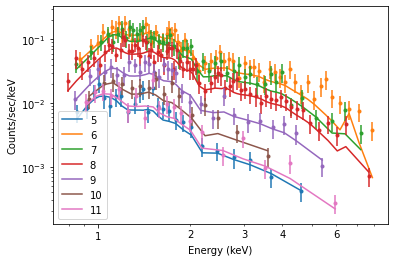

In [36]:
# Group for plotting purposes
ds2.group_counts(15)
# Need to group again, because sometimes edges of the new grouping don't align
# with the energy limits given before
ui.ignore(None, .4)
ui.ignore(10., None)

for i in ds2.get_stack_ids():
    dp = ui.get_fit_plot(i)
    dp.dataplot.overplot()
    
    ax = plt.gca()
    # add newest line
    line = ax.get_lines()[-1]
    dp.modelplot.overplot(color=line.get_color())
    
ax.set_xlabel(dp.dataplot.xlabel)
ax.set_ylabel(dp.dataplot.ylabel)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(ds2.get_stack_ids())
ax.get_xaxis().set_minor_formatter(MyLogFormatter())
ax.get_xaxis().set_major_formatter(MyLogFormatter())

Now I have fewer counts at the hot end, so I can't really say how well the 6.7 keV line (or is it a 6.4 keV?) line is fitted. Need to add NuStar data - that's why we took it!

In [38]:
ds2.conf()

Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 228.48
Final fit statistic   = 173.347 at function evaluation 91
Data points           = 263
Degrees of freedom    = 246
Probability [Q-value] = 0.999862
Reduced statistic     = 0.704663
Change in statistic   = 55.1331
   absall.nH      0.0580842    +/- 0.0514876   
   vall.kT        0.972398     +/- 0.155128    
   vall.norm      3.10914e-05  +/- 1.29415e-05 
   v5.kT          3.20848      +/- 0.63065     
   v5.norm        0.000172254  +/- 2.08926e-05 
   v6.kT          10.7121      +/- 2.80325     
   v6.norm        0.00424203   +/- 0.000213901 
   v7.kT          5.29142      +/- 0.729549    
   v7.norm        0.00314238   +/- 0.000193149 
   v8.kT          5.51214      +/- 0.985557    
   v8.norm        0.00191156   +/- 9.96208e-05 
   v9.kT          4.0468       +/- 0.604485    
   v9.norm        0.000798835  +/- 5.81316e-05 
   v10.kT         3.21573      +/- 0.696375    
   v10.norm       

In [52]:
c = ui.get_conf_results()

In [53]:
c

Parameter,Best-fit value,Lower Bound,Upper Bound
absall.nH,0.0580842,-0.0497241,0.0593628
vall.kT,0.972398,-0.174426,0.158216
vall.norm,3.10914e-05,-1.21033e-05,1.44308e-05
v5.kT,3.20848,-0.565158,0.777088
v5.norm,0.000172254,-2.06122e-05,2.13406e-05
v6.kT,10.7121,-2.75486,6.38912
v6.norm,0.00424203,-0.000214488,0.000226205
v7.kT,5.29142,-0.777374,0.943445
v7.norm,0.00314238,-0.000190359,0.000213118
v8.kT,5.51214,-0.741147,0.993911


In [79]:
timebins_mid = np.mean(spec_many_times, axis=1) / 1e3
timebins_halfwidth = 0.5 * (spec_many_times[:, 1] - spec_many_times[:, 0]) / 1e3

Text(0.5, 0, 'time [ks]')

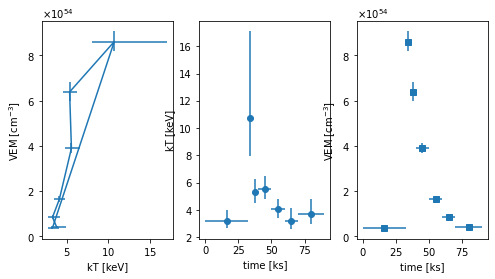

In [96]:
fig, axes = plt.subplots(ncols=3, figsize=(8,4))
# Now it pays off that my models are just named v + the dataset id. That way, 
# it's easy to loop of the model names.
axes[0].errorbar(x=[c.parvals[c.parnames.index(f'v{i}.kT')] for i in c.datasets],
                 y=[c.parvals[c.parnames.index(f'v{i}.norm')] / normfac for i in c.datasets],
                 # Sherpa gives the minimum as a negative number, while numpy expects it
                 # to be the absolute (i.e. positive) value
                 xerr=[[-c.parmins[c.parnames.index(f'v{i}.kT')] for i in c.datasets],
                       [c.parmaxes[c.parnames.index(f'v{i}.kT')] for i in c.datasets]],
                 yerr=[[-c.parmins[c.parnames.index(f'v{i}.norm')] / normfac for i in c.datasets],
                       [c.parmaxes[c.parnames.index(f'v{i}.norm')] / normfac for i in c.datasets]]

                )
axes[0].set_xlabel('kT [keV]')
axes[0].set_ylabel('VEM [cm$^{-3}$]')
axes[0].ticklabel_format(useMathText=True)

out1 = axes[1].errorbar(x=timebins_mid,
                 xerr=timebins_halfwidth,
                 y=[c.parvals[c.parnames.index(f'v{i}.kT')] for i in c.datasets],
                 yerr=[[-c.parmins[c.parnames.index(f'v{i}.kT')] for i in c.datasets],
                       [c.parmaxes[c.parnames.index(f'v{i}.kT')] for i in c.datasets]],
                fmt='o', label='temperature')
axes[1].set_ylabel('kT [keV]')
axes[1].set_xlabel('time [ks]')

out2 = axes[2].errorbar(x=timebins_mid,
            xerr=timebins_halfwidth,
            y=[c.parvals[c.parnames.index(f'v{i}.norm')] / normfac for i in c.datasets],
            yerr=[[-c.parmins[c.parnames.index(f'v{i}.norm')] / normfac for i in c.datasets],
                       [c.parmaxes[c.parnames.index(f'v{i}.norm')] / normfac for i in c.datasets]],
            fmt='s', label='VEM')
axes[2].set_ylabel('VEM [cm$^{-3}$]')
axes[2].ticklabel_format(useMathText=True)
axes[2].set_xlabel('time [ks]')


*left:* Volume emission measure (VEM)-KT diagram, *middle*: temperature of flare component with time and *right*, emission measure with time

It's interesting to see that the temperature has a second "hump" around 40 ks, which corresponds to a second hump in the lightcurve (see above), but the VEM has the classic exponential decay that we expect in the flare.

Obviously (that's why we did this observations after all), there will be a big benefit from folding in the NuStar data to get a handle on the righer temperatures. A particular point of interested is the 6.7 / 6.4 keV line.

In [189]:
# Above, I've used sherpa to fit the X-ray spectra. 
# Sherpa has two layers to interdface with it. 
# One is through an XSPEC like User interface (UI) layer, e.g. with
# "set_source(some string here that describes the source model)"
# The other way is more pythonic - data, model, statistics, fitter etc, are objects.
# The functionality is the same, just the way of typig is different.
# Sometimes I use one way, and sometimes the other, depnding on how I feel
# and if I follow along a particular example in the documentation.
# For the pythonic, object-oriented way, I need to import the classes I need into Python.

from sherpa.data import Data1D
from sherpa.plot import DataPlot, ModelPlot  # Of course, we could just plot with matplotlib directly.
                                  # Sherpa just has a few convenience functions, which I may use or not
from sherpa.models.basic import Exp
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar
from sherpa.fit import Fit



In [102]:
# maybe it's eaiser to turn VEM values and errors into numpy arrays first
# so that lines are not too long when I type
vem = np.array([c.parvals[c.parnames.index(f'v{i}.norm')] / normfac for i in c.datasets])
vemerr = np.array([[-c.parmins[c.parnames.index(f'v{i}.norm')] / normfac for i in c.datasets],
                       [c.parmaxes[c.parnames.index(f'v{i}.norm')] / normfac for i in c.datasets]])

In [190]:
d = Data1D(name='VEM', x=timebins_mid[1:],
              # devide by 1e52 because model has numeric problems for huge numbers
             y=vem[1:] / 1e52,  #  Don't include the pre-flare time bin into the fit
             staterror=np.mean(np.abs(vemerr), axis=0)[1:] / 1e52)  # Chi^2 does not know about asymmetric
                                                         # errors, so take mean

In [226]:
stat = Chi2()
opt = LevMar()
expmodel = Exp()
# Set somehwat reasonable starting values to increase the chance that the fit converges
expmodel.ampl = vem.max() / 1e52
expmodel.coeff = -1
expmodel.offset = timebins_mid[1]
vemfit = Fit(d, expmodel, stat=stat, method=opt)

In [227]:
expmodel

<Exp model instance 'exp'>

In [228]:
res = vemfit.fit()

In [229]:
res

Parameter,Best-fit value,Approximate error
exp.offset,35.9567,± 0.490154
exp.coeff,-0.0732456,± 0.00253393
exp.ampl,733.76,± 0


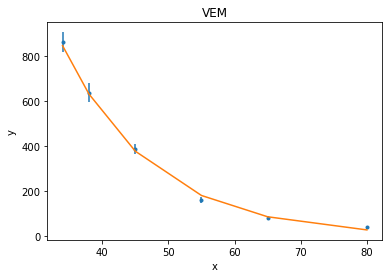

In [230]:
dplot = DataPlot()
dplot.prepare(d)
dplot.plot()
mplot = ModelPlot()
mplot.prepare(d, expmodel)
mplot.overplot()

In [234]:
1./expmodel.coeff.val

-13.652699858249026

So, the exponential decay time si about 13.5 ks. Sounds good to me! Now, I could go and look up the Reale et al loop models and check if the flare loop is likely to connect to the accretion disk (see the Favata paper on the ONC flares in COUP) and start to write the interpretation. But, before I do that, better get the NuStar data folded in!